In [ ]:
import pandas as pd
import numpy as np
import time
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Input, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import random
from nltk.corpus import wordnet
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

In [ ]:
# Memuat dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/ID_Quora_Paraphrasing_train.csv'
data = pd.read_csv(file_path)

# Ambil 50% data sebagai sampel
data = data.sample(frac=0.2, random_state=42)

# Preprocessing Dataset
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    text = re.sub(r'\d+', '', text)      # Hapus angka
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi berlebih
    return text

data['question_1'] = data['question_1'][:50000].apply(preprocess_text)
data['question_2'] = data['question_2'][:50000].apply(preprocess_text)

In [ ]:
# Tokenisasi dan pembuatan kamus kata
tokenizer_text1 = tf.keras.preprocessing.text.Tokenizer()
tokenizer_text2 = tf.keras.preprocessing.text.Tokenizer()

tokenizer_text1.fit_on_texts(data['question_1'])
tokenizer_text2.fit_on_texts(data['question_2'])

text1_sequences = tokenizer_text1.texts_to_sequences(data['question_1'])
text2_sequences = tokenizer_text2.texts_to_sequences(data['question_2'])

In [ ]:
# Padding
max_text1_len = max(len(seq) for seq in text1_sequences)
max_text2_len = max(len(seq) for seq in text2_sequences)
text1_sequences = tf.keras.preprocessing.sequence.pad_sequences(text1_sequences, maxlen=max_text1_len, padding='post')
text2_sequences = tf.keras.preprocessing.sequence.pad_sequences(text2_sequences, maxlen=max_text2_len, padding='post')

# Split dataset
# X_train, X_temp, y_train, y_temp = train_test_split(text1_sequences, text2_sequences, test_size=0.4, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    text1_sequences, text2_sequences, test_size=0.2, random_state=42
)

# Display the number of samples in each dataset
print(f"Training samples: {len(X_train)}")
# print(f"Validation samples: {len(X_val)}")
# print(f"Testing samples: {len(X_test)}")

Training samples: 21453


In [ ]:
# Parameters
vocab_size_text1 = len(tokenizer_text1.word_index) + 1
vocab_size_text2 = len(tokenizer_text2.word_index) + 1
embedding_dim = 256
num_heads = 8
units = 512

# Positional Encoding function
def positional_encoding(seq_len, dim):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(dim)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
    angles = pos * angle_rates
    return np.concatenate([np.sin(angles[:, 0::2]), np.cos(angles[:, 1::2])], axis=-1)

In [ ]:
def transformer_block(inputs, num_heads, ff_units):
    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=units)(inputs, inputs)
    attention_output = Dropout(0.3)(attention_output)
    attention_output = LayerNormalization()(inputs + attention_output)  # Add & Normalize

    # Feed Forward Layer
    ff_output = Dense(ff_units, activation='relu')(attention_output)
    ff_output = Dropout(0.3)(ff_output)
    ff_output = Dense(units)(ff_output)  # Ensure consistency in output dimension

    if attention_output.shape[-1] != ff_output.shape[-1]:
        ff_output = Dense(attention_output.shape[-1])(ff_output)

    ff_output = LayerNormalization()(attention_output + ff_output)  # Add & Normalize

    return ff_output


# Define the Transformer Model
def build_transformer():
    # Encoder
    encoder_input = Input(shape=(max_text1_len,))
    encoder_embedding = Embedding(vocab_size_text1, embedding_dim)(encoder_input)
    encoder_positional_encoding = positional_encoding(max_text1_len, embedding_dim)
    encoder_embedding = encoder_embedding + encoder_positional_encoding

    # Apply Transformer Block
    encoder_output = transformer_block(encoder_embedding, num_heads=num_heads, ff_units=2048)

    # Decoder (for simplicity, using the same structure, this would normally differ)
    decoder_input = Input(shape=(max_text2_len,))
    decoder_embedding = Embedding(vocab_size_text2, embedding_dim)(decoder_input)
    decoder_positional_encoding = positional_encoding(max_text2_len, embedding_dim)
    decoder_embedding = decoder_embedding + decoder_positional_encoding

    # Apply Transformer Block
    decoder_output = transformer_block(decoder_embedding, num_heads=num_heads, ff_units=2048)

    # Final Dense Layer for output
    output = Dense(vocab_size_text2, activation='softmax')(decoder_output)

    # Model
    model = Model([encoder_input, decoder_input], output)
    return model

# Build and compile model
model = build_transformer()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# %%
# Callbacks for Learning Rate and Early Stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath='best_model_Transformer_{val_accuracy:.4f}.keras',  # Filepath to save the model
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='max',                # 'max' because we want the highest val_accuracy
    verbose=1
)
# Train model
start_time = time.time()
history = model.fit(
    [X_train, y_train],
    y_train,
    validation_split=0.2,
    batch_size=16,
    epochs=15,
    callbacks=[lr_scheduler, early_stopping, checkpoint]
)
training_time = time.time() - start_time

# Konversi waktu training ke menit
training_time_minutes = training_time / 60

print(f"Training time: {training_time:.2f} seconds ({training_time_minutes:.2f} minutes)")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 45)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 45, 256)        │      2,982,656 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 45, 256)        │              0 │ embedding_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_10 (Cast)            │ (None, 45, 256)        │              0 │ add_15[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_11 (Cast)            │ (None, 45, 256)        │              0 │ add_15[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_13   │ (None, 45, 256)        │      4,206,848 │ cast_10[0][0],         │
│ (MultiHeadAttention)      │                        │                │ cast_11[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 45, 256)        │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 45, 256)        │              0 │ add_15[0][0],          │
│                           │                        │                │ dropout_34[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_26    │ (None, 45, 256)        │            512 │ add_16[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_66 (Dense)          │ (None, 45, 2048)       │        526,336 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_35 (Dropout)      │ (None, 45, 2048)       │              0 │ dense_66[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_67 (Dense)          │ (None, 45, 512)        │      1,049,088 │ dropout_35[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_68 (Dense)          │ (None, 45, 256)        │        131,328 │ dense_67[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_17 (Add)              │ (None, 45, 256)        │              0 │ layer_normalization_2… │
│                           │                        │                │ dense_68[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_27    │ (None, 45, 256)        │            512 │ add_17[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 70)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├──────────────────────

 Total params: 11,891,587 (45.36 MB)

 Trainable params: 11,891,587 (45.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8129 - loss: 1.6948
Epoch 1: val_accuracy improved from -inf to 0.86081, saving model to best_model_Transformer_0.8608.keras
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - accuracy: 0.8129 - loss: 1.6943 - val_accuracy: 0.8608 - val_loss: 0.8447 - learning_rate: 0.0010
Epoch 2/15
1071/1073 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8660 - loss: 0.7857
Epoch 2: val_accuracy improved from 0.86081 to 0.89994, saving model to best_model_Transformer_0.8999.keras
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.8661 - loss: 0.7855 - val_accuracy: 0.8999 - val_loss: 0.6102 - learning_rate: 0.0010
Epoch 3/15
1072/1073 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9038 - loss: 0.5581
Epoch 3: val_accuracy improved from 0.89994 to 0.93179, saving model to best_model_Transformer_0.9318.keras
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.9038 - loss: 0.5580 - val_accuracy: 0.9318 - val_loss: 0.4273 -

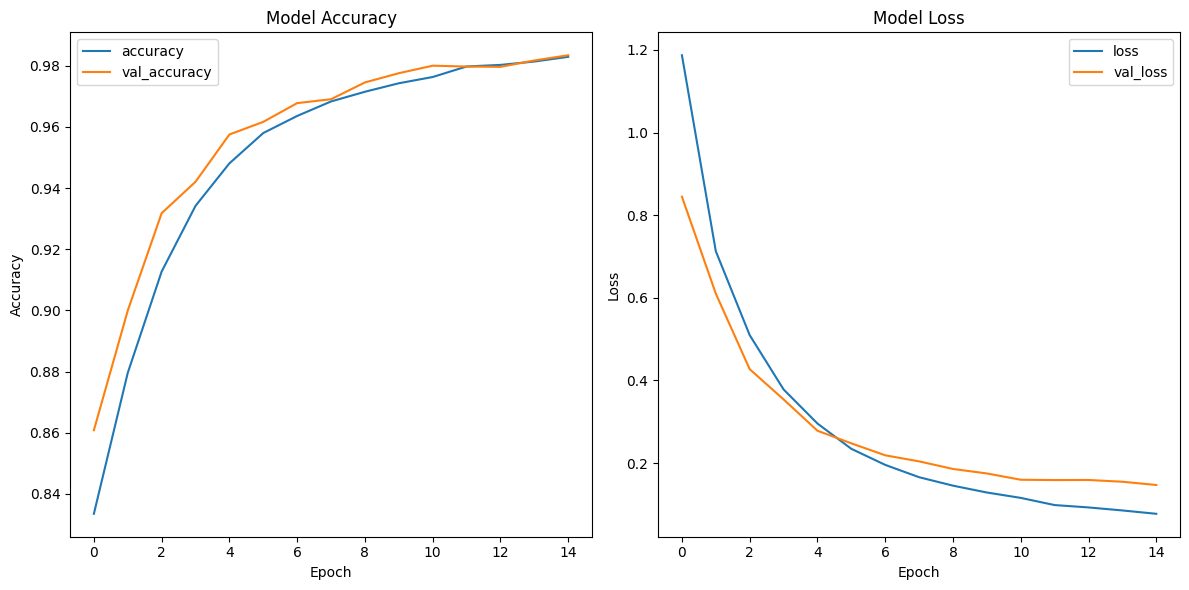

In [ ]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
# from rouge import Rouge
import numpy as np

# Fungsi untuk mendekode sequence token menjadi teks
def decode_sequence(sequence, tokenizer):
    words = [tokenizer.index_word[idx] for idx in sequence if idx > 0]  # Hindari token 0 (padding)
    return ' '.join(words)

# Tambahkan token khusus ke tokenizer jika belum ada
if '<start>' not in tokenizer_text2.word_index:
    tokenizer_text2.fit_on_texts(['<start> <end>'])

# Pastikan indeks token khusus tersedia
start_token = tokenizer_text2.word_index.get('<start>', 1)  # Default ke 1 jika tidak ditemukan
end_token = tokenizer_text2.word_index.get('<end>', 2)  # Default ke 2 jika tidak ditemukan

# Dekode prediksi dan referensi
# Inisialisasi input decoder dengan token <start> untuk prediksi awal
decoder_input = np.zeros((len(X_test), max_text2_len))
decoder_input[:, 0] = start_token  # Semua baris dimulai dengan token <start>

# Prediksi dari model
predictions = model.predict([X_test[:5], decoder_input[:5]])

# Dekode prediksi dan referensi
decoded_predictions = []
decoded_references = []

for i in range(len(predictions)):
    pred_tokens = predictions[i].argmax(axis=-1)
    ref_tokens = y_test[i]

    # Decode prediksi dan referensi
    decoded_predictions.append(decode_sequence(pred_tokens, tokenizer_text2))
    decoded_references.append(decode_sequence(ref_tokens, tokenizer_text2))

# Tokenisasi hasil prediksi dan referensi untuk evaluasi
tokenized_predictions = [pred.split() for pred in decoded_predictions]
tokenized_references = [ref.split() for ref in decoded_references]

# Evaluasi dengan BLEU
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smoothing_function = SmoothingFunction().method1
bleu_scores = [
    sentence_bleu([ref], pred, smoothing_function=smoothing_function)
    for ref, pred in zip(tokenized_references, tokenized_predictions)
]
avg_bleu_score = np.mean(bleu_scores)
print(f"Average BLEU score: {avg_bleu_score}")

for i, (input_seq, pred, ref, score) in enumerate(zip(X_test, decoded_predictions, decoded_references, bleu_scores)):
    # Decode input sequence
    input_text = decode_sequence(input_seq, tokenizer_text1)
    print(f"Input: {input_text}")
    print(f"Reference: {ref}")
    print(f"Prediction: {pred}")
    print(f"BLEU Score: {score:.4f}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Average BLEU score: 0.000255959116240962
Input: kualitas apa yang harus anda cari saat memutuskan apakah akan mengikuti seseorang di quora
Reference: apa yang anda klaim ketika anda mengikuti seseorang di quora
Prediction: apa
BLEU Score: 0.0000
--------------------------------------------------
Input: mengapa orang terkaya di inggris kebanyakan imigran
Reference: mengapa banyak orang persepsi di inggris memiliki pemecahan belakang asing
Prediction: apa
BLEU Score: 0.0000
--------------------------------------------------
Input: bagaimana cara menambahkan video dari youtube ke daftar putar dan kemudian mengunduh daftar putar itu
Reference: bagaimana cara saya mengunduh daftar putar
Prediction: apa
BLEU Score: 0.0000
--------------------------------------------------
Input: apa cara terbaik untuk mengurangi berat badan dengan cepat
Reference: apa cara terbaik untuk menurunkan berat badan dengan cepat
Prediction: apa
BLEU Score: 0.0001
--------------